In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
from collections import Counter

In [3]:
results_path = "./models/Reinforce_One_Dataset/"
datasets = list(map(os.path.basename, glob.glob(r"OneDatasetLearning/Classification/*")))

In [4]:
cv = ['train', 'test']

glob.glob(results_path + "*")
all_results = [(pd.read_csv(x, index_col=0), os.path.basename(x)) for x in glob.glob(results_path + "*")]

for curr_result_df, name in all_results:
    curr_result_df['delta_param'] = curr_result_df['origin_param'] / curr_result_df['new_param']
    curr_result_df['delta_acc'] = curr_result_df['new_acc'] - curr_result_df['origin_acc']

In [5]:
all_features = []
all_sizes = []

for curr_d in datasets:
    s, f = pd.read_csv(f'OneDatasetLearning/Classification/{curr_d}/{curr_d}.csv').shape
    all_sizes.append(s)
    all_features.append(f)


In [6]:
dataset_to_feature_size = dict([(x, all_features[idx]) for idx, x in enumerate(datasets)])
dataset_to_size = dict([(x, all_sizes[idx]) for idx, x in enumerate(datasets)])

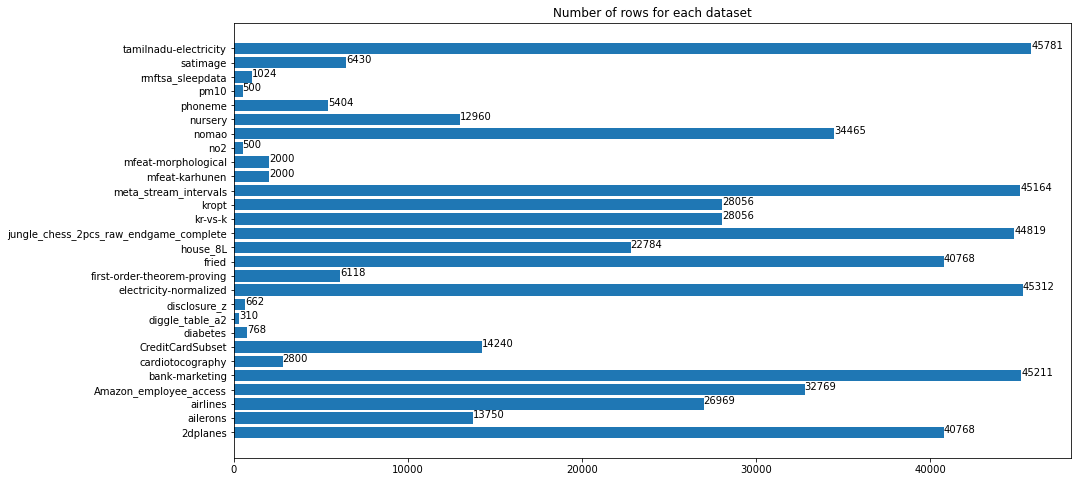

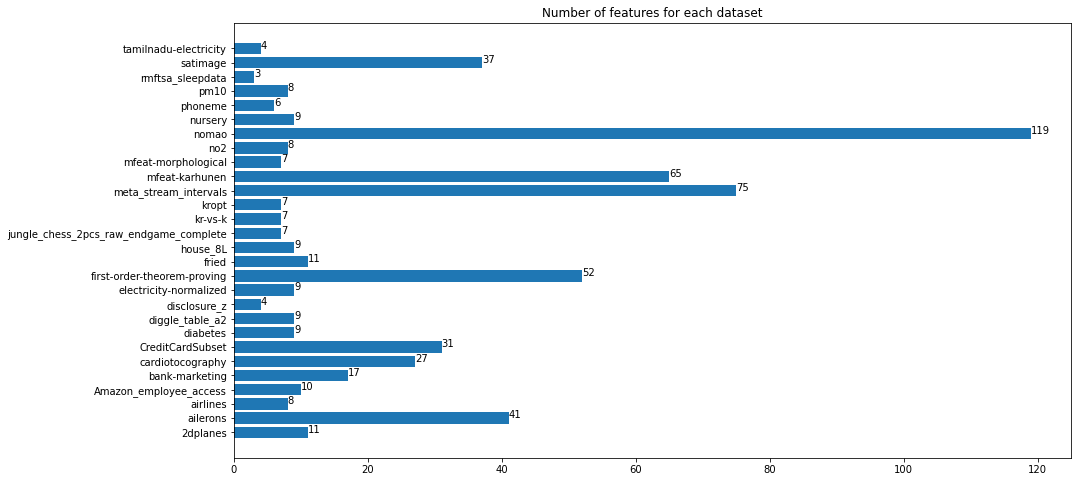

In [7]:
from matplotlib.pyplot import figure

figure(figsize = (15,8))
plt.barh(datasets, all_sizes)
plt.title("Number of rows for each dataset")
for index, value in enumerate(all_sizes):
    plt.text(value, index, str(value))
plt.show()

figure(figsize = (15,8))
plt.barh(datasets, all_features)
for index, value in enumerate(all_features):
    plt.text(value, index, str(value))
plt.title("Number of features for each dataset")
plt.show()

In [65]:
all_runs_lambdas = {
#     'NEON 4': lambda l: list(filter(lambda x: 'with_loop' in x[1] and
#                                                'Random_Actions' not in x[1] and
#                                                'single_test' not in x[1] and
#                                                'warmup' not in x[1], l)),
    'NEON 4 warmup': lambda l: list(filter(lambda x: 'with_loop' in x[1] and
                                         'Random_Actions' not in x[1] and
                                         'single_test' not in x[1] and
                                         'warmup' in x[1], l)),
#     'NEON 1': lambda l: list(filter(lambda x: 'with_loop' not in x[1] and 
#                                      'Random_Actions' not in x[1] and 
#                                      'LAP' not in x[1] and
#                                      'pruning' not in x[1] and
#                                      'Combined' not in x[1] and
#                                      'ADMM' not in x[1] and
#                                      'AMC' not in x[1] and
#                                      'warmup' not in x[1], l)),    
    'NEON 1 warmup': lambda l: list(filter(lambda x: 'with_loop' not in x[1] and 
                                         'Random_Actions' not in x[1] and 
                                         'LAP' not in x[1] and
                                         'pruning' not in x[1] and
                                         'Combined' not in x[1] and
                                         'ADMM' not in x[1] and
                                         'AMC' not in x[1] and
                                         'warmup' in x[1], l))
}

In [82]:
all_hyper_params_possibilities = ['0', '1', '5', '50']
all_data = []

for name, filter_func in all_runs_lambdas.items():

    relevant_logs = filter_func(all_results)
    relevant_logs = list(filter(lambda x: '_test' in x[1], relevant_logs))
    

    for idx, curr_acc_hp in enumerate(all_hyper_params_possibilities):
        all_deltas = []
        curr_group = list(filter(lambda x: re.search(r'acc_reduction_(\d{1,2})', x[1]).group(1) == curr_acc_hp, 
                                 relevant_logs))
        
        concatenated_relevant_result = pd.concat(list(map(lambda x: x[0], curr_group))).delta_acc * 100
        curr_acc_hp = int(curr_acc_hp)
        
        total_under_hp = (concatenated_relevant_result < -curr_acc_hp).sum()
        total_under_0 = ((concatenated_relevant_result >= -curr_acc_hp) & (concatenated_relevant_result <= 0)).sum()
        total_improved = (concatenated_relevant_result > 0).sum()
        
        total_under_hp = (concatenated_relevant_result < 0).sum()
        total_under_0 = (concatenated_relevant_result == 0).sum()
        total_improved = (concatenated_relevant_result > 0).sum()

        
        total_nets = len(concatenated_relevant_result)
        
        all_data.append([f'{name}_{curr_acc_hp}', 
                         total_under_hp / total_nets, 
                         total_under_0 / total_nets, 
                         total_improved / total_nets])

In [83]:
all_data

[['NEON 4 warmup_0',
  0.48214285714285715,
  0.20833333333333334,
  0.30952380952380953],
 ['NEON 4 warmup_1', 0.42857142857142855, 0.25, 0.32142857142857145],
 ['NEON 4 warmup_5',
  0.42857142857142855,
  0.22023809523809523,
  0.35119047619047616],
 ['NEON 4 warmup_50',
  0.4880952380952381,
  0.22023809523809523,
  0.2916666666666667],
 ['NEON 1 warmup_0',
  0.3869047619047619,
  0.35119047619047616,
  0.2619047619047619],
 ['NEON 1 warmup_1',
  0.4523809523809524,
  0.34523809523809523,
  0.20238095238095238],
 ['NEON 1 warmup_5',
  0.3273809523809524,
  0.47619047619047616,
  0.19642857142857142],
 ['NEON 1 warmup_50',
  0.47619047619047616,
  0.24404761904761904,
  0.27976190476190477]]

In [85]:
pd.DataFrame(all_data, columns = ['', 'Reduced', 'No Change', 'Imrpoved']).to_csv("test - allowed reduction hp.csv")

In [8]:
algo_lambdas = {
    '4_iterations_1_acc' : list(filter(lambda x: 'with_loop' in x[1] and 'Random_Actions' not in x[1] and 
                                       'single_test' not in x[1] and 'acc_reduction_1' in x[1], all_results)),
    
    '4_iterations_5_acc' : list(filter(lambda x: 'with_loop' in x[1] and 'Random_Actions' not in x[1] and 
                                       'single_test' not in x[1] and 'acc_reduction_5_' in x[1], all_results)),
    
    '4_iterations_50_acc' : list(filter(lambda x: 'with_loop' in x[1] and 'Random_Actions' not in x[1] and 
                                        'single_test' not in x[1] and 'acc_reduction_50_' in x[1], all_results)),
    
    '1_iteration_1_acc' : list(filter(lambda x: 'with_loop' not in x[1] and 
                                         'Random_Actions' not in x[1] and 
                                         'LAP' not in x[1] and
                                         'pruning' not in x[1] and
                                         'Combined' not in x[1] and
                                         'ADMM' not in x[1] and
                                         'AMC' not in x[1] and
                                         'acc_reduction_1' in x[1], all_results)),
    
    '1_iteration_5_acc' : list(filter(lambda x: 'with_loop' not in x[1] and 
                                         'Random_Actions' not in x[1] and 
                                         'LAP' not in x[1] and
                                         'pruning' not in x[1] and
                                         'Combined' not in x[1] and
                                         'ADMM' not in x[1] and
                                         'AMC' not in x[1] and
                                         'acc_reduction_5_' in x[1], all_results)),
    
    '1_iteration_50_acc' : list(filter(lambda x: 'with_loop' not in x[1] and 
                                         'Random_Actions' not in x[1] and 
                                         'LAP' not in x[1] and
                                         'pruning' not in x[1] and
                                         'Combined' not in x[1] and
                                         'ADMM' not in x[1] and
                                         'AMC' not in x[1] and
                                         'acc_reduction_50' in x[1], all_results))
}

In [9]:
results_by_algo = {}

for curr_algo_name in list(algo_lambdas):
    relevant_results = algo_lambdas[curr_algo_name]
    results_by_algo[curr_algo_name] = {}
    
    for curr_d in datasets:
        curr_dataset_results = list(filter(lambda x : curr_d in x[1], relevant_results))
        results_by_algo[curr_algo_name][curr_d] = {}

        for curr_cv in cv:
            curr_dataset_cv_results = list(filter(lambda x: curr_cv in x[1], curr_dataset_results))
            results_by_algo[curr_algo_name][curr_d][curr_cv] = curr_dataset_cv_results

In [10]:
len_of_test_nn = results_by_algo['4_iterations_1_acc']['2dplanes']['test'][0][0].shape[0]

In [86]:
all_groups = {}

for curr_k in algo_lambdas:
    all_groups[curr_k] = [0,0,0]

for ds_idx, curr_d in enumerate(datasets):
    for curr_nn_idx in range(len_of_test_nn):
        for curr_alg_name in list(algo_lambdas.keys()):
            curr_result_df = results_by_algo[curr_alg_name][curr_d]['train'][0][0]
            curr_result_name = results_by_algo[curr_alg_name][curr_d]['train'][0][1]
            curr_allowed_reduction = int(re.search(r"acc_reduction_(\d{1,2})_", curr_result_name).group(1))
            
            curr_delta_accs = (curr_result_df['delta_acc'] * 100)
            
            below_allowed = (curr_delta_accs < -curr_allowed_reduction).sum()
            between_allowe_and_zero = ((curr_delta_accs > -curr_allowed_reduction) & (curr_delta_accs <= 0)).sum()
            improved = (curr_delta_accs > 0).sum()
            
            all_groups[curr_alg_name][0] += below_allowed
            all_groups[curr_alg_name][1] += between_allowe_and_zero
            all_groups[curr_alg_name][2] += improved

In [87]:
all_groups

{'4_iterations_1_acc': [948, 2112, 972],
 '4_iterations_5_acc': [432, 2898, 702],
 '4_iterations_50_acc': [24, 2928, 1080],
 '1_iteration_1_acc': [648, 2868, 516],
 '1_iteration_5_acc': [360, 3042, 630],
 '1_iteration_50_acc': [30, 2958, 1044]}

In [88]:
all_rows = []
for curr_k in all_groups:    
    total_tests = sum(all_groups[curr_k])
    precentage = all_groups[curr_k] / total_tests
    all_rows.append([curr_k, *all_groups[curr_k], *precentage])
    

In [89]:
pd.DataFrame(all_rows, columns = ['Algorithm', '#below allowed', '#between allowed and zero', '#improved', 
                                  '%below allowed', '%between allowed and zero', '%improved']).to_csv("test - allowed reduction hp.csv")

# Histogram of accuracies for each agent

In [92]:
all_groups = {}

for curr_k in algo_lambdas:
    all_groups[curr_k] = []

for ds_idx, curr_d in enumerate(datasets):
    for curr_nn_idx in range(len_of_test_nn):
        for curr_alg_name in list(algo_lambdas.keys()):
            curr_result_df = results_by_algo[curr_alg_name][curr_d]['train'][0][0]
            curr_result_name = results_by_algo[curr_alg_name][curr_d]['train'][0][1]
                       
            curr_delta_accs = (curr_result_df['delta_acc'] * 100)
            all_groups[curr_alg_name].extend(curr_delta_accs)

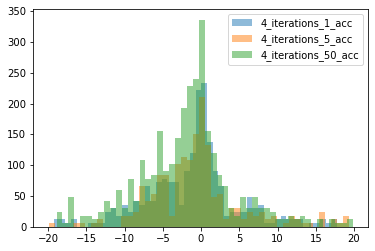

In [106]:
for curr_alg_name in all_groups:
    if '4_iterations' not in curr_alg_name : continue
    curr_data = np.array(all_groups[curr_alg_name])
    curr_data = curr_data[curr_data!=0]
    plt.hist(curr_data[(curr_data < 20) & (curr_data > -20)], label=curr_alg_name, bins = 50, alpha=0.5)
    
plt.legend()
plt.show()